 # Nomograms parameters validation on our data for n+ :)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import sys
import os

if 'notebooks' not in sys.path:
    sys.path.append('notebooks')
from unified_functions import plot_roc, plot_confusion_matrix



In [16]:
df = pd.read_csv('materials/processed_df.csv')

weights = {
    'Intercept': -5.83057151, 'Age': 0.00521158, 'PSA': 0.18754729,
    'PSA_S1': -0.00122617, 'PSA_S2': 0.0033653,
    'Gleason': {1: 0, 2: 1.52752948, 3: 2.57873595, 4: 2.75375893, 5: 3.50034615},
    'Stage': {'T2a': 0.26172062, 'T2b': 0.55860494, 'T2c': 0.84874365, 'T3+': 1.09527926}
}

def calc_splines(x, knots=[0.2, 4.8, 7.33, 307]):
    def pos(u): return np.maximum(u, 0)**3
    t1, t2, t3, t4 = knots
    k = (t4-t1)/(t4-t3)
    k2 = (t4-t2)/(t4-t3)
    s1 = pos(x-t1) - pos(x-t3)*k + pos(x-t4)*(t3-t1)/(t4-t3)
    s2 = pos(x-t2) - pos(x-t3)*k2 + pos(x-t4)*(t3-t2)/(t4-t3)
    return s1, s2

def map_stage(val):
    v = str(val).lower()
    if 't3' in v: return weights['Stage']['T3+']
    if 't2c' in v: return weights['Stage']['T2c']
    if 't2b' in v: return weights['Stage']['T2b']
    if 't2a' in v: return weights['Stage']['T2a']
    if 't1' in v: return 0.0
    return np.nan

val_df = df.copy()
val_df.columns = [c.strip() for c in val_df.columns]
val_df = val_df.dropna(subset=['PSA', 'wiek', 'Bx ISUP Grade', 'N +'])

val_df['S1'], val_df['S2'] = calc_splines(val_df['PSA'].values)
val_df['W_Gleason'] = val_df['Bx ISUP Grade'].map(weights['Gleason'])
val_df['W_Stage'] = val_df['TNM'].apply(map_stage)
val_df = val_df.dropna(subset=['W_Gleason', 'W_Stage'])

val_df['Logit'] = (
    weights['Intercept'] + 
    val_df['wiek']*weights['Age'] + 
    val_df['PSA']*weights['PSA'] + 
    val_df['S1']*weights['PSA_S1'] + 
    val_df['S2']*weights['PSA_S2'] + 
    val_df['W_Gleason'] + val_df['W_Stage']
)
val_df['Prob_MSKCC'] = 1 / (1 + np.exp(-val_df['Logit']))


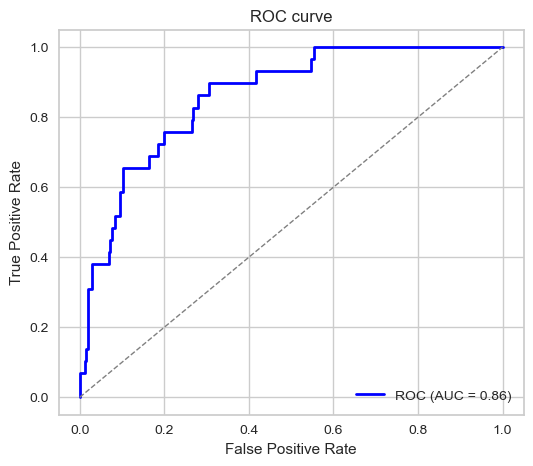

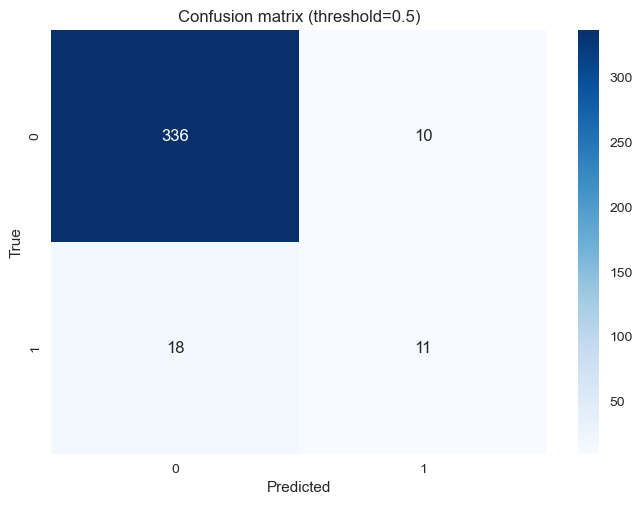

Sensitivity: 0.3793
Specificity: 0.9711
Accuracy: 0.9253%


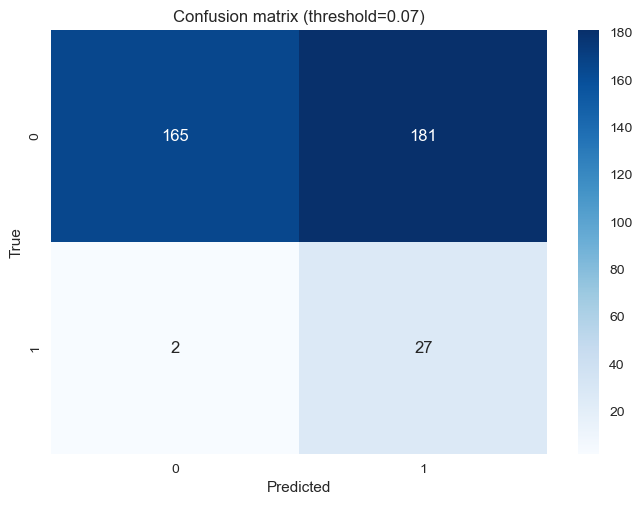

Sensitivity: 0.9310
Specificity: 0.4769
Accuracy: 0.5120%


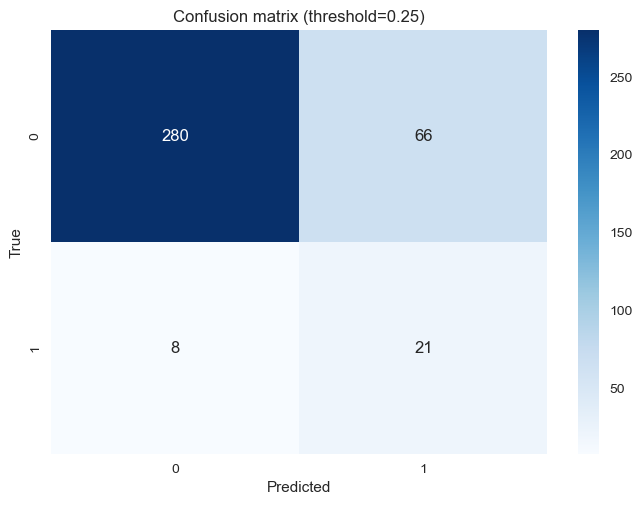

Sensitivity: 0.7241
Specificity: 0.8092
Accuracy: 0.8027%


In [ ]:
y_true = val_df['N +'].values
y_scores = val_df['Prob_MSKCC'].values

fpr, tpr, _ = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plot_roc(fpr, tpr, auc_score)
plot_confusion_matrix(y_true, y_pred_probs=y_scores, threshold=0.5)
plot_confusion_matrix(y_true, y_pred_probs=y_scores, threshold=0.07)
plot_confusion_matrix(y_true, y_pred_probs=y_scores, threshold=0.25)


#gdzie sa roznice? ktorzy pacjenci sa inaczej klasyfikowani? ktorzy sa dobrze a ktorzy zle?
# - moze zeby polaczyc pozniej nasz z ich modelem